In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
import os

%matplotlib inline

In [0]:
def img_pre1(image,plot):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  plt.title('gray')
  plt.imshow(gray)
  thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_TOZERO_INV)[1]
  thresh = cv2.erode(thresh, None, iterations=3)
  thresh = cv2.dilate(thresh, None, iterations=3)
  plt.title('thresh')
  plt.imshow(thresh)
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
  if plot:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)        
    plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)        
    plt.title('Original Image')            
    plt.subplot(1, 2, 2)
    plt.imshow(new_image)
    plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Cropped Image')        
    plt.imshow(new_image)    
  return new_image

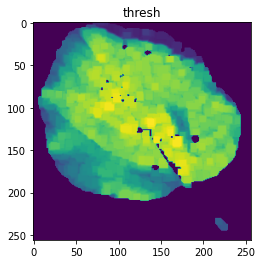

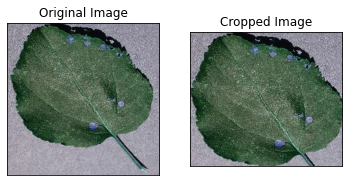

In [4]:
ex_img = cv2.imread( "/content/gdrive/My Drive/leaf image dataset 2/yes/image (1003).JPG" )
ex_new_img = img_pre1(ex_img, True)

In [0]:
def img_pre2(dlist,image_size):
  x=[]
  y=[]
  width,height=image_size
  for d in dlist:
    for fname in os.listdir(d):
      image=cv2.imread(d + '/' + fname)
      image=img_pre1(image,plot=False)
      image=cv2.resize(image,dsize=(width,height), interpolation=cv2.INTER_CUBIC)
      image=image/225.
      x.append(image)
      if(d[-3:] == 'yes'):
        y.append([1])
      else:
        y.append([0])
  x=np.array(x)
  y=np.array(y)
  x,y=shuffle(x,y)
  print('Number of example is: {}'.format(len(x)))
  print('x shape is: {}'.format(x.shape))
  print('y shape id: {}'.format(y.shape))
  return (x,y)

Number of example is: 1910
x shape is: (1910, 240, 240, 3)
y shape id: (1910, 1)


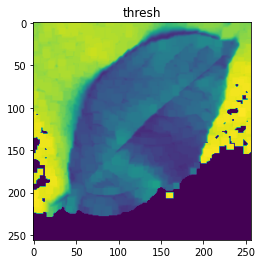

In [6]:
yes='/content/gdrive/My Drive/leaf image dataset 2/yes'
no='/content/gdrive/My Drive/leaf image dataset 2/no'
width,height=(240,240)
x,y=img_pre2([yes,no],(width,height))

**Ploting sample Images:**

In [0]:
def plot_images(x, y, n=50):
    for label in [0,1]:
        images = x[np.argwhere(y == label)]
        n_images = images[:n]/1.5   
        columns_n = 10
        rows_n = int(n/ columns_n)
        plt.figure(figsize=(20, 10))        
        i = 1      
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)            
            i += 1        
        label_to_str = lambda label: "Yes DATA" if label == 1 else "No DATA"
        plt.suptitle(label_to_str(label))
        plt.show()

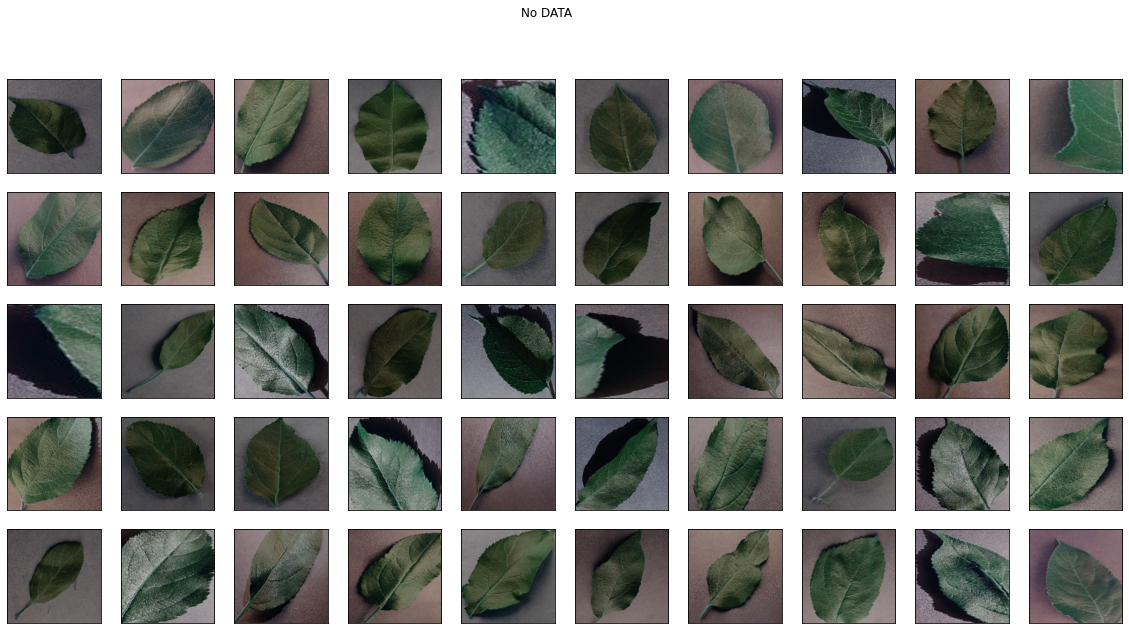

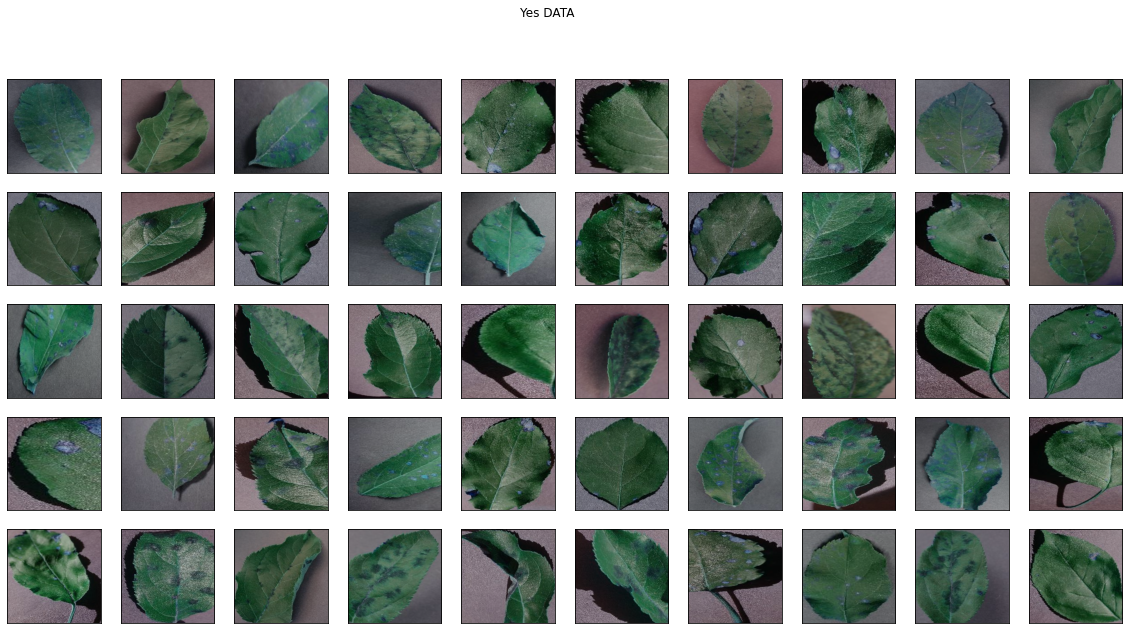

In [11]:
plot_images(x, y)

In [0]:
def split_data(x, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=test_size)
    x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [0]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(x, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(x_train.shape[0]))
print ("number of development examples = " + str(x_val.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(x_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1337
number of development examples = 287
number of test examples = 286
X_train shape: (1337, 240, 240, 3)
Y_train shape: (1337, 1)
X_val (dev) shape: (287, 240, 240, 3)
Y_val (dev) shape: (287, 1)
X_test shape: (286, 240, 240, 3)
Y_test shape: (286, 1)


In [0]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

**MODEL**

In [0]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
   

    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    

    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    

    X = Flatten()(X)

    X = Dense(1, activation='sigmoid', name='fc')(X)
  
    model = Model(inputs = X_input, outputs = X, name='LeafDieaseDetectionModel')
    
    return model

In [0]:
IMG_SHAPE = (width, height, 3)

In [0]:
model = build_model(IMG_SHAPE)

In [22]:
model.summary()

Model: "LeafDieaseDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
log_file_name = f'leaf_disease_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [25]:
start_time = time.time()
model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val),callbacks=[tensorboard])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
42/42 [==============================] - 64s 2s/step - loss: 0.6660 - accuracy: 0.7823 - val_loss: 0.4676 - val_accuracy: 0.8746
Epoch 2/10
42/42 [==============================] - 64s 2s/step - loss: 0.2920 - accuracy: 0.8848 - val_loss: 0.4834 - val_accuracy: 0.8537
Epoch 3/10
42/42 [==============================] - 64s 2s/step - loss: 0.2370 - accuracy: 0.9117 - val_loss: 0.7631 - val_accuracy: 0.4530
Epoch 4/10
42/42 [==============================] - 64s 2s/step - loss: 0.2261 - accuracy: 0.9245 - val_loss: 0.5746 - val_accuracy: 0.6934
Epoch 5/10
42/42 [==============================] - 64s 2s/step - loss: 0.1878 - accuracy: 0.9260 - val_loss: 0.2458 - val_accuracy: 0.8920
Epoch 6/10
42/42 [==============================] - 64s 2s/step - loss: 0.1808 - accuracy: 0.9372 - val_loss: 0.2597 - val_accuracy: 0.9268
Epoch 7/10
42/42 [==============================] - 67s 2s/step - loss: 0.1836 - accuracy: 0.9319 - val_loss: 0.2291 - val_accuracy: 0.9408
Epoch 8/10
42/42 [==

In [26]:
eva=model.evaluate(x_train,y_train,verbose=1)

42/42 [==============================] - 13s 314ms/step - loss: 0.1468 - accuracy: 0.9604
